 Dataset split created in: /kaggle/working/Malimg_split_moco
Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting MoCo Pretraining...
Epoch [1/100], MoCo Loss: 5.2080
Epoch [2/100], MoCo Loss: 5.5403
Epoch [3/100], MoCo Loss: 5.5473
Epoch [4/100], MoCo Loss: 5.2958
Epoch [5/100], MoCo Loss: 5.2507
Epoch [6/100], MoCo Loss: 5.2190
Early stopping triggered in pretraining!
Pretraining finished in 10.04 minutes
Starting Fine-tuning...
Epoch [1/100] Loss: 1.7370 | Train Acc: 0.4432
Epoch [2/100] Loss: 0.5797 | Train Acc: 0.7144
Epoch [3/100] Loss: 0.3230 | Train Acc: 0.7910
Epoch [4/100] Loss: 0.2047 | Train Acc: 0.8497
Epoch [5/100] Loss: 0.1300 | Train Acc: 0.8894
Epoch [6/100] Loss: 0.0983 | Train Acc: 0.8966
Epoch [7/100] Loss: 0.0610 | Train Acc: 0.9174
Epoch [8/100] Loss: 0.0539 | Train Acc: 0.9104
Epoch [9/100] Loss: 0.0466 | Train Acc: 0.9122
Epoch [10/100] Loss: 0.0447 | Train Acc: 0.9204
Epoch [11/100] Loss: 0.0379 | Train Acc: 0.9239
Epoch [12/100] Loss: 0.0412 | Train Acc: 0.9226
Epoch [13/100] Loss: 0.0346 | Train Acc: 0.9315
Epoch [14/100] Loss: 0.0362 | Train Acc: 0.9314
Epoch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 2000x2000 with 0 Axes>

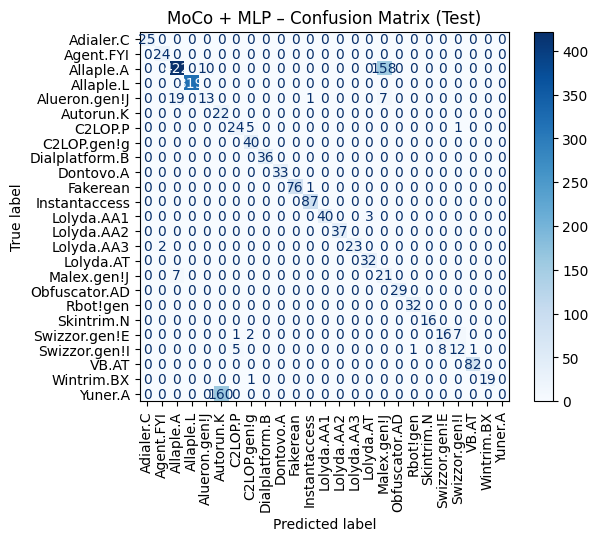

Class Adialer.C ROC-AUC: 1.0000
Class Agent.FYI ROC-AUC: 1.0000
Class Allaple.A ROC-AUC: 0.9843
Class Allaple.L ROC-AUC: 1.0000
Class Alueron.gen!J ROC-AUC: 0.9115
Class Autorun.K ROC-AUC: 0.9569
Class C2LOP.P ROC-AUC: 0.9974
Class C2LOP.gen!g ROC-AUC: 0.9989
Class Dialplatform.B ROC-AUC: 1.0000
Class Dontovo.A ROC-AUC: 1.0000
Class Fakerean ROC-AUC: 0.9998
Class Instantaccess ROC-AUC: 1.0000
Class Lolyda.AA1 ROC-AUC: 0.9999
Class Lolyda.AA2 ROC-AUC: 1.0000
Class Lolyda.AA3 ROC-AUC: 0.9914
Class Lolyda.AT ROC-AUC: 0.9999
Class Malex.gen!J ROC-AUC: 0.9270
Class Obfuscator.AD ROC-AUC: 1.0000
Class Rbot!gen ROC-AUC: 1.0000
Class Skintrim.N ROC-AUC: 1.0000
Class Swizzor.gen!E ROC-AUC: 0.9960
Class Swizzor.gen!I ROC-AUC: 0.9912
Class VB.AT ROC-AUC: 1.0000
Class Wintrim.BX ROC-AUC: 1.0000
Class Yuner.A ROC-AUC: 0.9936
Macro-average ROC-AUC: 0.9899


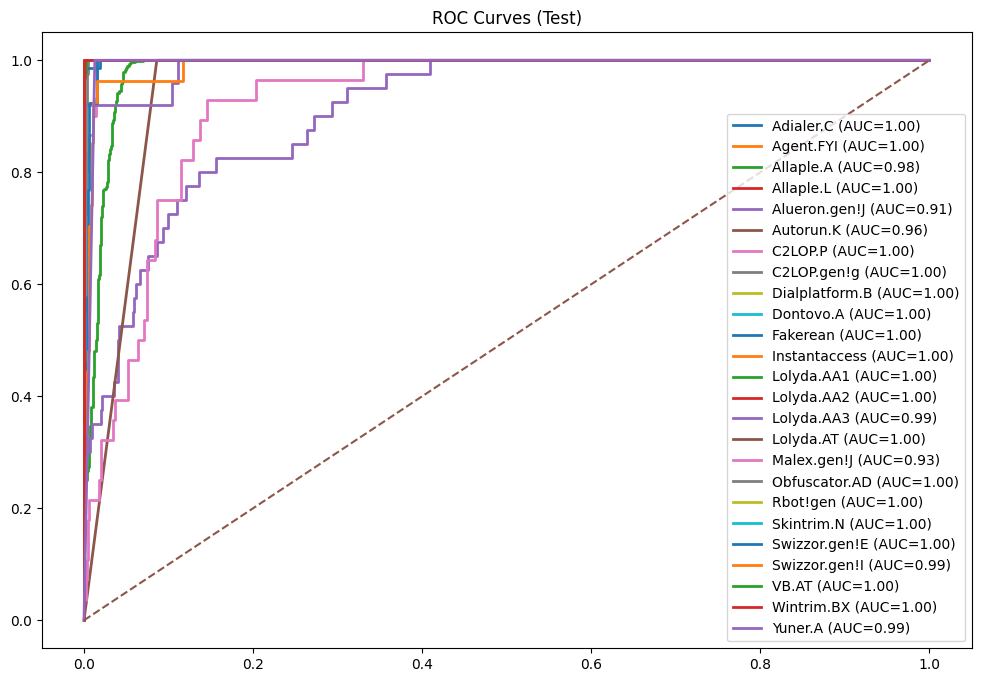

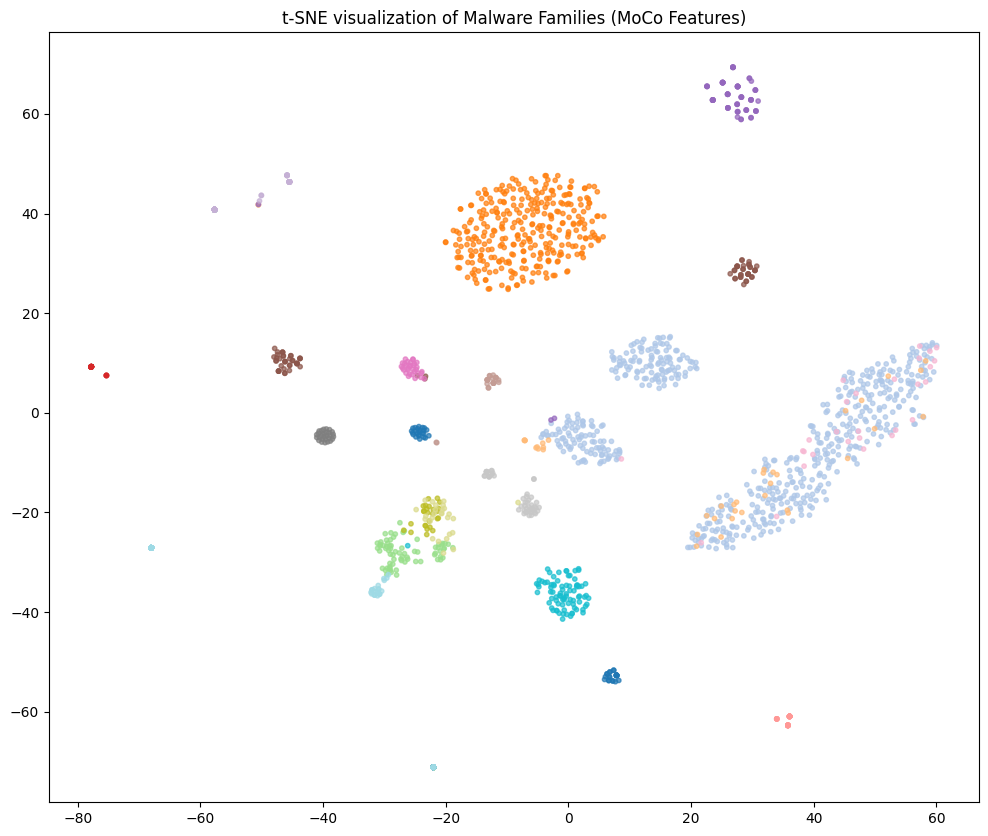

In [1]:
# ============================================
# MoCo (v2-style) Training + Eval on Malimg
# + Early Stopping, Timing, Classification Report
# ============================================

import os
import random
import shutil
import time
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image

# -----------------------------
# 0) Repro / Device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True


# -----------------------------
# 1) Paths & Split (train/test only)
# -----------------------------
root_dir = "/kaggle/input/malimg"
working_dir = "/kaggle/working/Malimg_split_moco"

train_ratio, test_ratio = 0.8, 0.2
splits = ["train", "test"]
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

os.makedirs(working_dir, exist_ok=True)
for s in splits:
    os.makedirs(os.path.join(working_dir, s), exist_ok=True)

needs_split = any(len(os.listdir(os.path.join(working_dir, s))) == 0 for s in splits)

if needs_split:
    for cls in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        images = [os.path.join(class_dir, f)
                  for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            images = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True)
                      if os.path.isfile(p) and p.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            continue

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)

        assigns = {
            "train": images[:n_train],
            "test": images[n_train:]
        }

        for s in splits:
            dest_dir = os.path.join(working_dir, s, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for src in assigns[s]:
                shutil.copy2(src, dest_dir)
    print(" Dataset split created in:", working_dir)
else:
    print(" Using existing split in:", working_dir)


# -----------------------------
# 2) Transforms
# -----------------------------
pretrain_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

clf_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


# -----------------------------
# 3) Two-views dataset for MoCo
# -----------------------------
class ImageFolderTwoViews(ImageFolder):
    def __init__(self, root, base_transform):
        super().__init__(root, transform=None)
        self.base_transform = base_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if isinstance(img, Image.Image) is False:
            img = Image.open(path).convert("RGB")
        im1 = self.base_transform(img)
        im2 = self.base_transform(img)
        return (im1, im2), target


# -----------------------------
# 4) Datasets & Loaders (with imbalance handling)
# -----------------------------
pretrain_dataset = ImageFolderTwoViews(
    os.path.join(working_dir, "train"), base_transform=pretrain_transform
)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=128, shuffle=True, drop_last=True)

train_dataset = ImageFolder(os.path.join(working_dir, "train"), transform=clf_transform)
test_dataset  = ImageFolder(os.path.join(working_dir, "test"),  transform=clf_transform)

# Weighted sampler for imbalance
targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


# -----------------------------
# 5) MoCo (v2-style) Model
# -----------------------------
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        m = resnet18(pretrained=False)
        m.fc = nn.Identity()
        self.encoder = m
    def forward(self, x):
        return self.encoder(x)

class MLPHead(nn.Module):
    def __init__(self, in_dim=512, hidden=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class MoCo(nn.Module):
    def __init__(self, feature_dim=128, K=16384, m=0.99, T=0.07):
        super().__init__()
        self.K, self.m, self.T = K, m, T
        self.encoder_q = ResNetBackbone()
        self.encoder_k = ResNetBackbone()
        self.mlp_q = MLPHead()
        self.mlp_k = MLPHead()
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]; ptr = int(self.queue_ptr); end = ptr + batch_size
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first_len = self.K - ptr
            self.queue[:, ptr:] = keys[:first_len].T
            self.queue[:, :end - self.K] = keys[first_len:].T
        self.queue_ptr[0] = (end) % self.K
    def forward(self, im_q, im_k):
        q_feat = self.encoder_q(im_q)
        q = nn.functional.normalize(self.mlp_q(q_feat), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k_feat = self.encoder_k(im_k)
            k = nn.functional.normalize(self.mlp_k(k_feat), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        with torch.no_grad(): self._dequeue_and_enqueue(k)
        return logits, labels


# -----------------------------
# 6) Pretrain MoCo (with Early Stopping + Timing)
# -----------------------------
moco = MoCo().to(device)
optimizer = optim.Adam(moco.parameters(), lr=1e-3)
epochs_ssl = 100
patience_ssl = 5
best_loss, wait = float("inf"), 0

print("Starting MoCo Pretraining...")
start_time = time.time()

moco.train()
for epoch in range(epochs_ssl):
    total_loss = 0.0
    for (im1, im2), _ in pretrain_loader:
        im_q, im_k = im1.to(device), im2.to(device)
        logits, labels = moco(im_q, im_k)
        loss = nn.CrossEntropyLoss()(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(pretrain_loader)
    print(f"Epoch [{epoch+1}/{epochs_ssl}], MoCo Loss: {avg_loss:.4f}")
    # Early stopping check
    if avg_loss < best_loss:
        best_loss, wait = avg_loss, 0
        torch.save(moco.encoder_q.state_dict(), "moco_Malimg.pth")
    else:
        wait += 1
        if wait >= patience_ssl:
            print("Early stopping triggered in pretraining!")
            break

pretrain_time = time.time() - start_time
print(f"Pretraining finished in {pretrain_time/60:.2f} minutes")


# -----------------------------
# 7) Fine-tuning with 2-layer MLP classifier (with Early Stopping + Timing)
# -----------------------------
backbone = resnet18(pretrained=False); backbone.fc = nn.Identity()
backbone.load_state_dict(torch.load("moco_Malimg.pth"), strict=False)
backbone = backbone.to(device)

for name, p in backbone.named_parameters():
    p.requires_grad = ("layer4" in name)

classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
).to(device)

params_to_opt = list(classifier.parameters()) + [p for p in backbone.parameters() if p.requires_grad]
optimizer_cls = optim.Adam(params_to_opt, lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer_cls, step_size=10, gamma=0.5)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

epochs_cls = 100
patience_cls = 5
best_acc, wait = 0, 0

print("Starting Fine-tuning...")
start_time = time.time()

for epoch in range(epochs_cls):
    backbone.train(); classifier.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        feats = backbone(images)
        logits = classifier(feats)
        loss = criterion(logits, labels)
        optimizer_cls.zero_grad(); loss.backward(); optimizer_cls.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs_cls}] Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
    scheduler.step()
    # Early stopping check
    if train_acc > best_acc:
        best_acc, wait = train_acc, 0
        torch.save({"backbone": backbone.state_dict(), "classifier": classifier.state_dict()}, "best_model.pth")
    else:
        wait += 1
        if wait >= patience_cls:
            print("Early stopping triggered in fine-tuning!")
            break

fine_tune_time = time.time() - start_time
print(f"Fine-tuning finished in {fine_tune_time/60:.2f} minutes")


# -----------------------------
# 8) Test Evaluation + Avg Inference Time
# -----------------------------
checkpoint = torch.load("best_model.pth")
backbone.load_state_dict(checkpoint["backbone"])
classifier.load_state_dict(checkpoint["classifier"])
backbone.eval(); classifier.eval()

t_correct, all_preds, all_labels, all_probs = 0, [], [], []
start_infer = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        feats = backbone(images)
        logits = classifier(feats)
        probs = torch.softmax(logits, dim=1)
        t_correct += (logits.argmax(1) == labels).sum().item()
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
infer_time = time.time() - start_infer

test_acc = t_correct / len(test_dataset)
avg_infer_time = infer_time / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Average Inference Time per Image: {avg_infer_time*1000:.2f} ms")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))


# -----------------------------
# 9) Confusion Matrix + ROC-AUC + t-SNE
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, values_format='d')
plt.title("MoCo + MLP – Confusion Matrix (Test)"); plt.show()

num_classes = len(test_dataset.classes)
labels_onehot = label_binarize(all_labels, classes=np.arange(num_classes))
roc_auc_per_class = roc_auc_score(labels_onehot, all_probs, average=None)
for i, cls in enumerate(test_dataset.classes):
    print(f"Class {cls} ROC-AUC: {roc_auc_per_class[i]:.4f}")
print(f"Macro-average ROC-AUC: {roc_auc_score(labels_onehot, all_probs, average='macro'):.4f}")

plt.figure(figsize=(12, 8))
for i, cls in enumerate(test_dataset.classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title("ROC Curves (Test)"); plt.show()

# t-SNE
all_feats = []
with torch.no_grad():
    for images, labels in test_loader:
        feats = backbone(images.to(device))
        all_feats.append(feats.cpu())
all_feats = torch.cat(all_feats, dim=0).numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeds = tsne.fit_transform(all_feats)
plt.figure(figsize=(12,10))
plt.scatter(embeds[:,0], embeds[:,1], c=all_labels, cmap="tab20", s=10, alpha=0.7)
plt.title("t-SNE visualization of Malware Families (MoCo Features)")
plt.show()
